# Regression discontinuity

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns, warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
from causalgraphicalmodels import CausalGraphicalModel
from cProfile import label
%matplotlib inline

Interest in "regression-discontinuity design" (RDD) has increased in recent years. This aims to determine the causal effects of interventions by assigning a cut-off point or threshold above or below which the intervention is assigned. 


To be more sure of the method it is necessary to take into account the following definitions.

- Execution variable ($X$): it is the variable that determines if it receives treatment or not
- Cutoff ($c_0$): It is the **limit** of the variable where it is determined if it receives treatment or not, the norms behind cutoff are those that did not receive treatment, and those on the right are those that did.
- Bandwidth ($h$): It is the amount of area around the limit that is willing to be considered comparable.
- Treatment ($D$): Represents if you received the treatment (1) or not (0)




In [ ]:

sprinkler = CausalGraphicalModel(
    nodes=["RunningVariable", "AboveCutoff", "Treatment", "Z", "Outcome"],
    edges=[
        ("Z", "RunningVariable"), 
        ("RunningVariable", "AboveCutoff"), 
        ("RunningVariable", "Outcome"),
        ("AboveCutoff", "Treatment"), 
        ("Z", "Outcome"), 
        ("Treatment", "Outcome")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

In the graph, $X$ (**RunningVariable**)  is a **continuous variable** assigning units to treatment  $D(X \rightarrow D)$. This assignment of units to treatment is based on a “cutoff” score $c_0$  such that any unit with a score above the cutoff gets placed into the treatment group, and units below do not. 

The assignment variable may itself independently affect the outcome via the  $X \rightarrow Y$ path and may even be related to a set of variables $Z$ that independently determine $Y$. Notice for the moment that a unit’s treatment status is exclusively determined by the assignment rule. Treatment is not determined by $Z$.

The main assumption of this design is the continuity of the variable $X$, since any discontinuity necessarily implies some cause.

In Regression Discontinuity, 2 types of RDD studies are accepted. There are designs in which the probability of treatment goes from 0 to 1 at the cut-off point, (“shap” design), as an example of this design, we can take the reinforcements that can received. And others where the probability increases at the “fuzzy” design cut-off point, a discontinuous jump in the probability of treatment is experienced.

Formally the Sharp design:

$$
D_i =
   \begin{cases} 1
       \text{si} & X_i\geq{c_0}
       \\ 0
       \text{ if } & X_i < c_0
   \end{cases}
$$

and the “Fuzzy” design is:

$$
\lim_{X_i\rightarrow{c_0}}
   \Pr\large(D_i=1\mid X_i=c_0\large) \ne
   \lim_{c_0 \leftarrow X_i}
   \Pr\large(D_i=1\mid X_i=c_0\large)
$$


Illustratively, the designs are shown as follows.

![](figs/rdd-dessing.png)

In order to estimate the effect, we can follow the following steps:

- Choose the cutoff point of the “running variable”
- Choose the **correct** model and predict the values near the limit
- Estimate the “jump” in the “cutoff”

## Aplications

### Simulated Data

For this we will build a database, which the treated observations will be those that have a value of at least 50, with a real effect of 40 (note inside the equation: $40 * D$),

$$
    Y = 25 + 40*D + 1.5 * X + e
$$

In [ ]:
## Random data
dat = pd.DataFrame({'x': np.random.normal(50, 25, 1000)})
dat.loc[dat.x<0, 'x'] = 0
dat = dat[dat.x<100]
dat['D'] = 0
# Cutoff
dat.loc[dat.x>50, 'D'] = 1
# Simulated Y
dat['y'] = 25 + 40*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])
# Not Treatment
dat_0 = dat[dat.D == 0]
# Treatment
dat_1 = dat[dat.D == 1]

Visually there is an increase in the cut-off point

In [ ]:
# Colors 
treat_c = "#568A9B" # Treatment
n_treat = "#A10728" # Not treatment
# Plot
plt.scatter("x", "y", data = dat_0, color = n_treat, alpha= .7, s = 7, label = "Not treatment")
plt.scatter("x", "y", data = dat_1, color = treat_c, alpha= .7, s = 7, label = "Treatment")
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff")
plt.legend();

Now we estimate a model for each side, in this case the model that would best fit would be the linear model, for this we generate a function to include the predictions in the database.

In [ ]:

def y_hat_lin(da_ta, x = "x", y = "y"):
    yhat = smf.ols(f"{y} ~ {x}", data = da_ta).fit().predict()
    da_ta["yhat"] = yhat
    da_ta.sort_values('yhat', inplace = True)
    return da_ta

data_y0 = y_hat_lin(dat_0)
data_y1 = y_hat_lin(dat_1)

Predictions

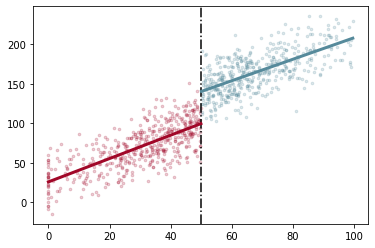

In [ ]:
plt.scatter("x", "y", data = dat_0, color = n_treat, alpha= .2, s = 7, label = "Not treatment")
plt.scatter("x", "y", data = dat_1, color = treat_c, alpha= .2, s = 7, label = "Treatment")
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff")

plt.plot("x", "yhat", data = data_y0, color = n_treat, lw = 3)
plt.plot("x", "yhat", data = data_y1, color = treat_c, lw = 3);

In order to measure the jump (Effect), for this case we will only focus on the last observation predicted for the left side and the first predicted for the left side since a jump is observed there.

In [ ]:
eff = min(data_y1.yhat) - max(data_y0.yhat)
eff = round(eff,  2)
print("Effect:", f"{eff}")

Effect 40.74


Visually we can see the effect at the cutoff point, remember that the real effect is 40 units

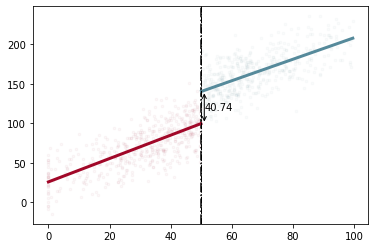

In [ ]:

plt.scatter("x", "y", data = dat_0, color = n_treat, alpha= .03, s = 7, label = "Not treatment")
plt.scatter("x", "y", data = dat_1, color = treat_c, alpha= .03, s = 7, label = "Treatment")
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff")

plt.plot("x", "yhat", data = data_y0, color = n_treat, lw = 3)
plt.plot("x", "yhat", data = data_y1, color = treat_c, lw = 3)
plt.axvline(50, color = "black", linestyle = "-.", label = r"$c_0$: Cutoff", lw = 1)
plt.annotate(f"{eff}", xy = (51, eff + 76))
plt.annotate("", xy = (51, max(data_y0.yhat)), xytext = (51, min(data_y1.yhat)), 
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"));

## Kernel Weighting

Additionally, to correctly evaluate the effect, the closest observations to the cutoff must be “weighed” differently in the limit compared to the observations farthest from it. For this, the triangular kernel can be used.

$$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \left(1-\frac{|R-c|}{h}\right)
$$

These weights are divided by the bandwidth ($h$). If the bandwidth is large, the weights get smaller at a slower rate. If the bandwidth is small, the weights are quickly reduced to zero.

In python the code is:

In [ ]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

## Aplication: Is Alcohol Killing You?

A very relevant public policy question is what should be the minimal drinking age. Most countries, Brazil included, set it to be 18 year, but in the US (most states) it is currently 21. So, is it the case that the US is being overly prudent and that they should lower their minimal drinking age?

### Load the data

In [ ]:
drinking = pd.read_csv("https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/drinking.csv")

var_rel = ["agecell", "all", "mva", "suicide"]


drinking = drinking[var_rel]

# define the cutoff in 21

drinking["agecell"] -= 21

# treatment
drinking["threshold"]  = (drinking["agecell"] > 0).astype(int)


Visually, with a cutoff point of 0 and a bandwidth of 1, the weights will be distributed as follows

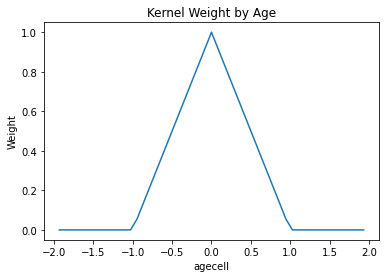

In [ ]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

In [ ]:
# Not Treatment
drink_0 = drinking[drinking["agecell"] < 0]
# Treatment
drink_1 = drinking[drinking["agecell"] >= 0]

we repeat the steps we saw in the first application, and measure the impact, with the difference that now we will use `smf.wls` instead of `smf.ols`, the functions produce the same results without the `weight` parameter, while if we assign the values to the parameter with the weights of the observations (triangular kernel), the results of the regression will change

In [ ]:
def y_hat_lin(da_ta, x = "x", y = "y"):
    da_ta = da_ta.dropna()

    yhat = smf.wls(f"{y} ~ {x} * threshold", data = da_ta).fit().predict()
    da_ta["yhat"] =  np.array(yhat)
    da_ta.sort_values(x, inplace = True)
    return da_ta


def rdd(data0, data1, x = "agecell", y = "all"):


    globals() ["drink_y0"] = y_hat_lin(data0, x, y)
    globals() ["drink_y1"] = y_hat_lin(data1, x, y)
    l1, l0 = max(drink_y1.yhat), max(drink_y0.yhat)

    plt.plot(x,  "yhat", data = drink_y1)
    plt.plot(x,  "yhat", data = drink_y0)
    plt.scatter(x,  y, data = drink_y1)
    plt.scatter(x,  y, data = drink_y0)
    
    eff = round(100*(((l1 - l0) + l0)/l0 - 1), 2)
    plt.title(f"RDD without kernel:\nEffect {eff} %")


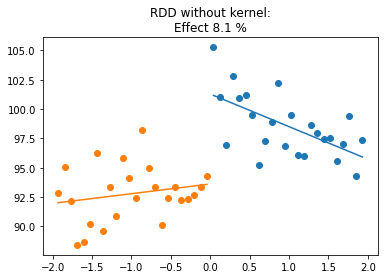

In [ ]:
rdd(drink_0, drink_1)

In [ ]:
da_ta = drinking.dropna()
## triangular kernel
weights = kernel(da_ta["agecell"], 0 , h = 1)
# weights
yhat = smf.wls(f"all ~ agecell * threshold", data = da_ta, weights = weights).fit().predict()
da_ta["yhat"] =  np.array(yhat)
# # return yhat
da_ta.sort_values("agecell", inplace = True)


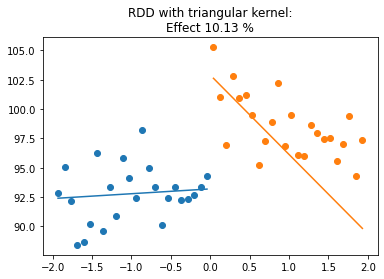

In [ ]:
drink_nt = da_ta[da_ta["agecell"] < 0]
drink_t = da_ta[da_ta["agecell"] >= 0]

l1, l0 = max(drink_t.yhat), max(drink_nt.yhat)

eff = round(100*(((l1 - l0) + l0)/l0 - 1), 2)

plt.plot("agecell", "yhat", data = drink_nt)
plt.plot("agecell", "yhat", data = drink_t)
plt.scatter("agecell", "all", data = drink_nt)
plt.scatter("agecell", "all", data = drink_t)
plt.title(f"RDD with triangular kernel:\nEffect {eff} %");

Applying the formula with the weights, we have that the effect goes from 8.1% without the triangular kernel, to 10.13% with the triangular kernel.